# 📊 Prédiction d'approbation de prêt bancaire avec régression logistique 

<div style="text-align: center;">
  <img src="image.png" alt="Image centrée" >
</div>

## <span style="color:purple"> I-chargement des données</span>


In [329]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [330]:
data=pd.read_csv("loan_dataset.csv")
data.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


#####  <span style="color:green">description des variables</span>


- Loan_ID : Identifiant du prêt
- Gendre : Sexe du demandeur 
- Married : status marital (oui ou non)
- Dependents : Nombre de personnes à charge
- Education : niveau d'éducation
- Self_Employed : travail indépendant ou non 
- ApplicantIncome : revenu du demandeur 
- CoapplicantIncome : Revenu du co-demandeur 
- LoanAmount :  Montant du prêt demandé
- Loan_Amount_Term: durée du prêt
- Credit_History :  Historique de crédit (1 = bon, 0 = mauvais)
- Property_area : Zone de résidence (urbaine, semi-urbaine, rurale)
- loan_status :situation du prêt (la demande est approuvée ou non )

In [333]:
data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [334]:
data.shape

(614, 13)

-  <span style="color:green">variable cible</span>  : *Loan_status* 
- <span style="color:green">les variables explicatives</span> : *Gendre*, *Married*, *Dependents*, *Education*, *Self_Employed*, *ApplicantIncome*, *CoapplicantIncome*, *LoanAmount*, *Loan_Amount_Term*, *Credit_History*, *Property_area*

<span style="color:red">❓ Problématique : </span>
<blockquote style="color: black; font-style: italic; text-align: center;">
  Comment prédire efficacement l’approbation d’un prêt bancaire à partir des caractéristiques socio-économiques et financières d’un demandeur ?
</blockquote>

<span style="color:red">🎯 L'objectif : </span>
<blockquote style="color: black; font-style: italic; text-align: center;">
  développer un modèle de classification qui puisse, à partir d'informations comme le revenu, l'historique de crédit ou le statut familial, anticiper la décision finale d'approbation d’un prêt.
</blockquote>

## <span style="color:purple"> II-Préparation des données </span>

#####  <span style="color:green">Nettoyages des valeurs manquantes </span>

In [335]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


> - les variables <span style="color:green">Gender, Married, Dependents, Self_Employed, LoanAmount, Loan_Amount_Term, Credit_history</span> contient des valeur manquantes 
> - pour régler ce probléme on va remplacer les valeurs manquantes par la valeur la plus fréquente , mediane , moyenne, etc. 

In [336]:
for col in ['Gender','Married','Dependents','Self_Employed','Loan_Amount_Term']:
    data[col].fillna(data[col].mode()[0],inplace=True)

In [337]:
data['LoanAmount'].fillna(data['LoanAmount'].median(),inplace=True)

La variable Credit_History contient un nombre important de valeurs manquantes. Les supprimer entraînerait une perte significative d'informations potentiellement utiles sur les clients. Pour éviter cela, nous choisissons de remplacer les valeurs manquantes par -1, ce qui permettra au modèle de considérer ces cas comme des informations inconnues plutôt que de les ignorer complètement.

In [338]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
data['Credit_History'] = imputer.fit_transform(data[['Credit_History']])

c:\Users\PC\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [339]:
data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

>  Toutes les valeurs manquantes ont été traitées avec des méthodes appropriées . Le dataset ne contient désormais plus de valeurs manquantes.

#####  <span style="color:green">Suppression des doublons </span>

In [340]:
data.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
609    False
610    False
611    False
612    False
613    False
Length: 614, dtype: bool

In [341]:
data.duplicated().sum()

0

> Aucune ligne dupliquée n’a été détectée dans le dataset.

 #####  <span style="color:green">Encodage des variables catégorielles </span>

In [342]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [343]:
data['Loan_Status']=data['Loan_Status'].map({'Y':1,'N':0})

In [344]:
data['Gender']=data['Gender'].map({'Male':1,'Female':0})

In [345]:
data['Married']=data['Married'].map({'Yes':1,'No':0})

In [346]:
data['Education']=data['Education'].map({'Graduate':1,'Not Graduate':0})

In [347]:
data['Self_Employed']=data['Self_Employed'].map({'Yes':1,'No':0})

In [348]:
data['Dependents']=data['Dependents'].replace('3+',3).astype(int)

In [349]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,1,0,5849,0.0,128.0,360.0,1.0,Urban,1
1,LP001003,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,Urban,1


## <span style="color:purple"> III-Analyse exploratoire des données (EDA) </span>

 #####  <span style="color:green">Statistiques descriptives </span>

In [350]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    int64  
 2   Married            614 non-null    int64  
 3   Dependents         614 non-null    int32  
 4   Education          614 non-null    int64  
 5   Self_Employed      614 non-null    int64  
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(4), int32(1), int64(6), object(2)
memory usage: 60.1+ KB


In [351]:
data.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.817590,0.653094,0.744300,0.781759,0.133550,5403.459283,1621.245798,145.752443,342.410423,0.855049,0.687296
std,0.386497,0.476373,1.009623,0.413389,0.340446,6109.041673,2926.248369,84.107233,64.428629,0.352339,0.463973
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2877.500000,0.000000,100.250000,360.000000,1.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3812.500000,1188.500000,128.000000,360.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,5795.000000,2297.250000,164.750000,360.000000,1.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000,1.000000


 #####  <span style="color:green">Analyse de la variable cible: Loan_status </span>

In [352]:
data['Loan_Status'].value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

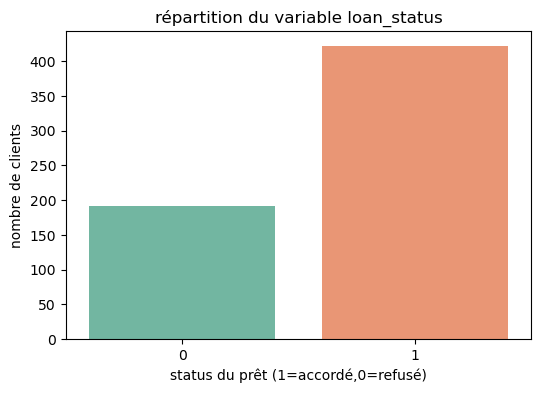

In [353]:
plt.figure(figsize=(6,4))
sns.countplot(data=data,x='Loan_Status',palette='Set2')
plt.title('répartition du variable loan_status')
plt.xlabel("status du prêt (1=accordé,0=refusé)")
plt.ylabel("nombre de clients")
plt.show()

> Le graphique ci-dessus montre une répartition déséquilibrée, avec davantage de prêts accordés que refusés.

 #####  <span style="color:green">Analyse univariée des variables explicatives </span>

Créer une fonction pour tracer **le countplot** pour chaque variable catégorielle


In [354]:
def plt_countplot(variable,data=data,palette='Set2',hue=None):
    plt.figure(figsize=(6,4))
    sns.countplot(data=data, x=variable,hue=hue, palette=palette)
    plt.title(f"Distribution de la variable '{variable}'")
    plt.xlabel(variable)
    plt.ylabel("Nombre d'observations")
    plt.show()

  <span style="color:blue">Gender </span>

In [355]:
data['Gender'].value_counts()

1    502
0    112
Name: Gender, dtype: int64

> Le nombre de demandeurs hommes est de 502, tandis qu'il n'y a que 112 femmes.

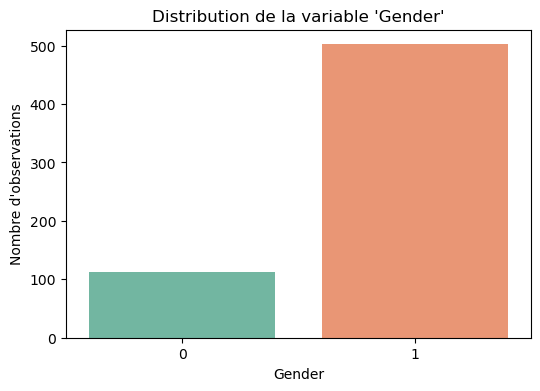

In [356]:
plt_countplot('Gender',data=data,palette='Set2',hue=None)

<span style="color:blue">Married </span>

In [357]:
data['Married'].value_counts()

1    401
0    213
Name: Married, dtype: int64

> Le nombre de demandeurs mariés est de 401, tandis qu'il n'y a que 213 célibataires.

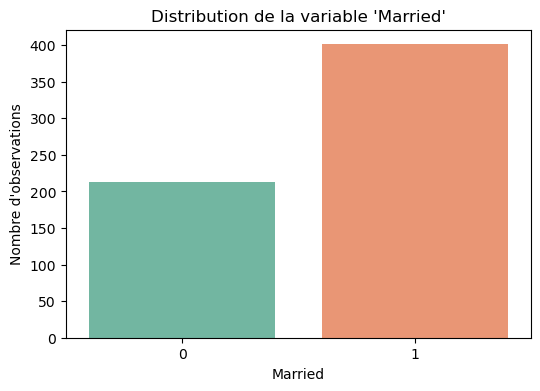

In [358]:
plt_countplot('Married',data=data, hue=None)

<span style="color:blue">Education </span>

In [359]:
data['Education'].value_counts()

1    480
0    134
Name: Education, dtype: int64

> La plupart des demandeurs sont diplômés de l’enseignement supérieur. 

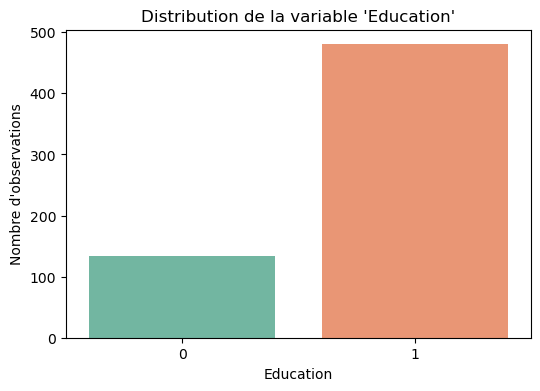

In [360]:
plt_countplot('Education',data=data,hue=None)

<span style="color:blue">Self Employed </span>

In [361]:
data['Self_Employed'].value_counts()

0    532
1     82
Name: Self_Employed, dtype: int64

> Le nombre de salariés est largement dominant : 532 personnes ne sont pas auto-entrepreneurs, contre seulement 82 qui le sont.

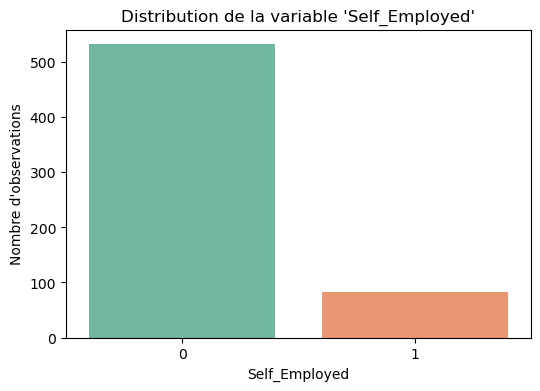

In [362]:
plt_countplot('Self_Employed')

<span style="color:blue">Loan_Amount_Term : la durée du prét </span>

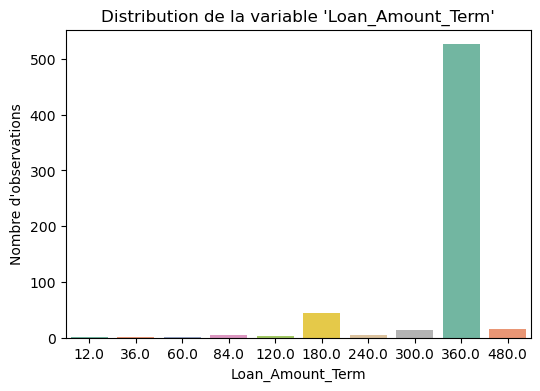

In [363]:
plt_countplot('Loan_Amount_Term',data=data,hue=None)

<span style="color:blue">Property_Area </span>

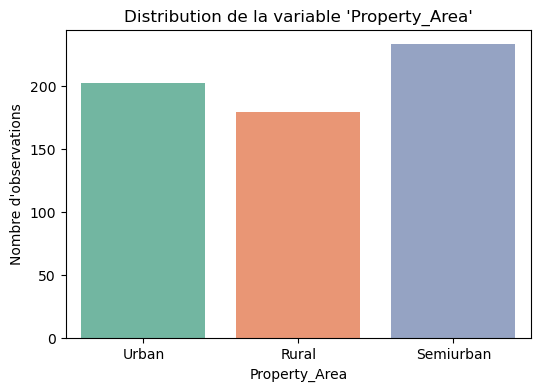

In [364]:
plt_countplot('Property_Area')

> La distribution de la variable Propery_Area est equilibrée entre Urbain, Rural et Semiurban

<span style="color:blue">Credit_History </span>

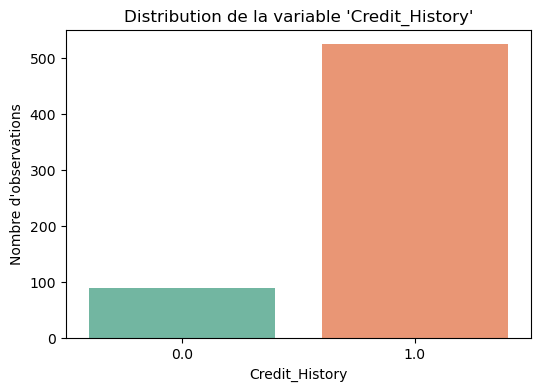

In [365]:
plt_countplot('Credit_History')

> - on observe que la majoritée ont un bon historique avec les crédits 

Créer une fonction pour tracer **l'histogramme** pour chaque variable numérique

In [366]:
def plot_histogram(variable, data=data, bins=30, color='skyblue'):
    plt.figure(figsize=(6,4))
    sns.histplot(data[variable], bins=bins, kde=True, color=color)
    plt.title(f"Distribution de la variable '{variable}'")
    plt.xlabel(variable)
    plt.ylabel("Fréquence")
    plt.show()

Créer une fonction pour tracer **le box plot** pour chaque variable catégorielle

In [367]:
def plot_boxplot(variable, data=data):
    plt.figure(figsize=(6,4))
    sns.boxplot(y=data[variable], color='lightgreen')
    plt.title(f"Boxplot de la variable '{variable}'")
    plt.ylabel(variable)
    plt.show()


<span style="color:blue">ApplicantIncome </span>

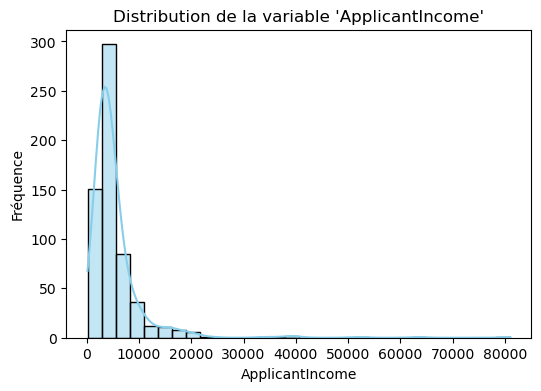

In [368]:
plot_histogram('ApplicantIncome',data=data,bins=30,color='skyblue')

> La distribution est fortement asymétrique à droite  :
> - la majorité des revenues se situent entre 0 et 10 000 dh 
> - il y a des valeurs très élevès jusqu'à 80 000 
> - La densité est très concentrée au début de l’axe des X, autour de 2 500 à 5 000.


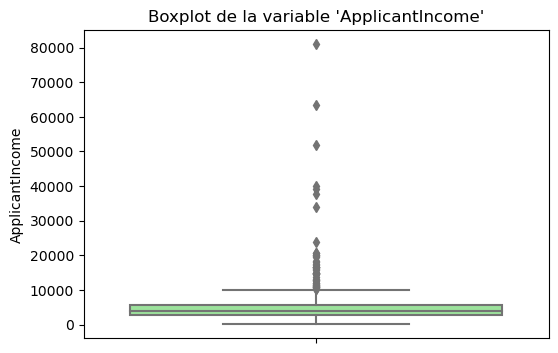

In [369]:
plot_boxplot('ApplicantIncome',data=data)

> - une forte présence des valeurs abérantes  : Tous les points au-dessus de la "boîte" sont des individus avec un revenu bien plus élevé que la majorité.
> - La ligne dans la boîte représente la médiane des revenus (valeur centrale), probablement autour de 3 000 à 4 000.

<span style="color:blue">CoapplicantIncome </span>

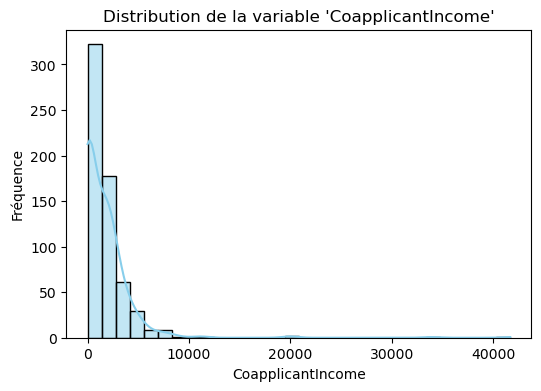

In [370]:
plot_histogram('CoapplicantIncome',data=data,bins=30,color='skyblue')

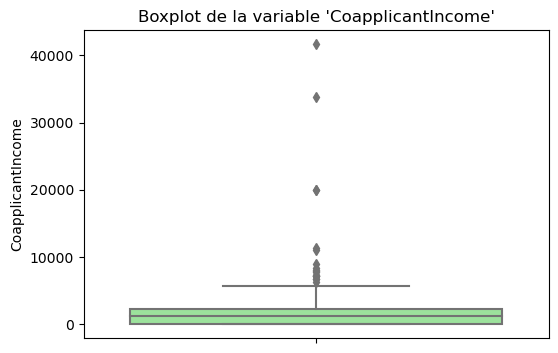

In [371]:
plot_boxplot('CoapplicantIncome',data=data)

<span style="color:blue">LoanAmount </span>

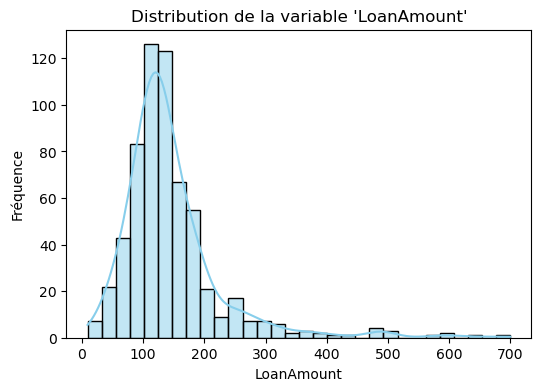

In [372]:
plot_histogram('LoanAmount',data=data,bins=30,color='skyblue')

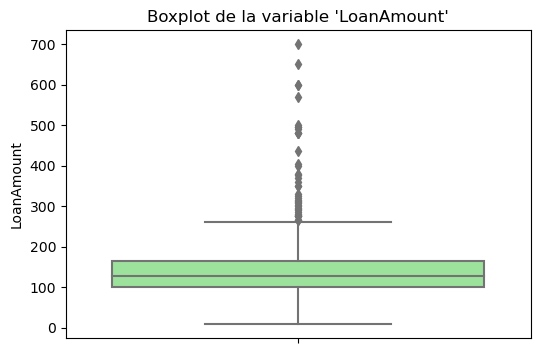

In [373]:
plot_boxplot('LoanAmount',data=data)

> La distribution est clairement asymétrique à droite, avec une longue queue vers les valeurs élevées. Cela signifie :
> - La majorité des demandes de prêt sont concentrées sur des montants relativement faibles (probablement entre 0 et 200 unités, selon l'échelle).
> - Quelques valeurs extrêmes (outliers) s'étendent jusqu'à 500–700 unités, tirant la moyenne vers la droite.


 #####  <span style="color:green">Analyse bivariée (variable cible : Loan_status VS les autres variables ) </span>

<span style="color:blue">Loan_Status VS les variables catégorielles </span>

Les Hypothéses 

> - H0 : les deux variables sont indépendantes 
> - H1 : il y a un lien entre les deux variables  

 Test **Chi2**

In [374]:
from scipy.stats import chi2_contingency
def chi2_test(var):
    table = pd.crosstab(data[var], data['Loan_Status'])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"Variable: {var}")
    print(" p-value:", p)
    sns.countplot(data=data, x=var, hue='Loan_Status')
    plt.title(f"Loan_Status par {var}")
    plt.show()

<span style="color:skyblue">Loan_Status VS Gender </span>

In [375]:
pd.crosstab(data['Gender'],data['Loan_Status'])

Loan_Status,0,1
Gender,,
0,37,75
1,155,347


Variable: Gender
 p-value: 0.7391461310869638


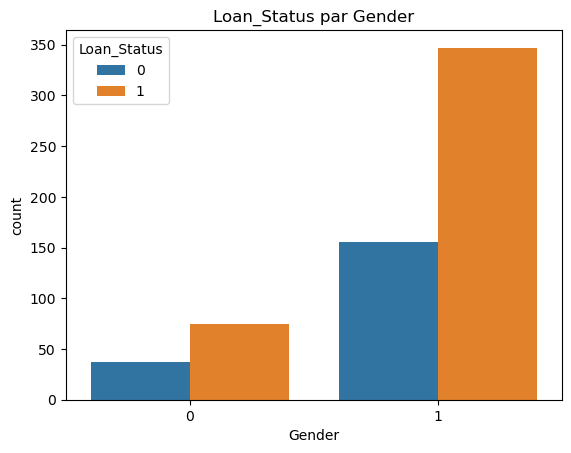

In [376]:
chi2_test('Gender')

> sachant que le p_value > 0.05  donc on accepte H0 c'est à dire les deux variables sont indépendantes : le sexe du demandeur n'influe pas la décision d'acceptation du pret 

<span style="color:skyblue">Loan_Status VS Married </span>

In [377]:
pd.crosstab(data['Married'],data['Loan_Status'])

Loan_Status,0,1
Married,,
0,79,134
1,113,288


Variable: Married
 p-value: 0.029608580862582116


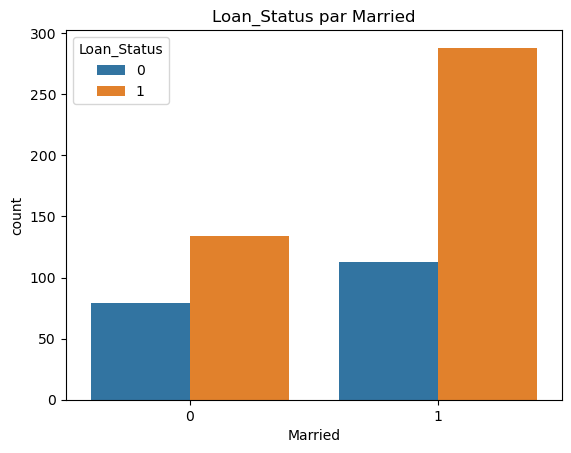

In [378]:
chi2_test('Married')

> -  La p-value étant inférieure à 0,05, on rejette l’hypothèse nulle. Il existe donc une relation significative entre les variables Married et Loan_Status
> - On peut supposer que les personnes mariées sont perçues comme plus stables financièrement, ce qui pourrait augmenter leurs chances d'obtenir un prêt.


<span style="color:skyblue">Loan_Status VS Education </span> 

In [379]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,1,0,5849,0.0,128.0,360.0,1.0,Urban,1
1,LP001003,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,Urban,1


In [380]:
pd.crosstab(data['Education'],data['Loan_Status'])

Loan_Status,0,1
Education,,
0,52,82
1,140,340


Variable: Education
 p-value: 0.04309962129357353


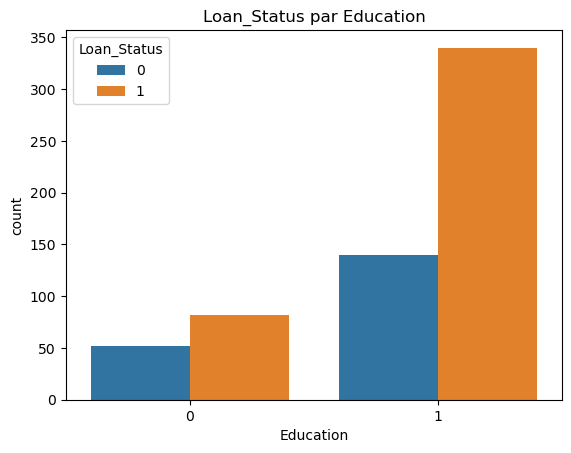

In [381]:
chi2_test('Education')

> -  La p-value étant inférieure à 0,05, on rejette l’hypothèse nulle. Il existe donc une relation significative entre les variables Education et Loan_Status
> - On peut supposer que les personnes diplômées ont généralement un emploi plus stable et un revenu plus élevé que les non-diplômés, ce qui peut influencer positivement la décision d'acceptation de leur demande de prêt.


<AxesSubplot:xlabel='Loan_Status', ylabel='Education'>

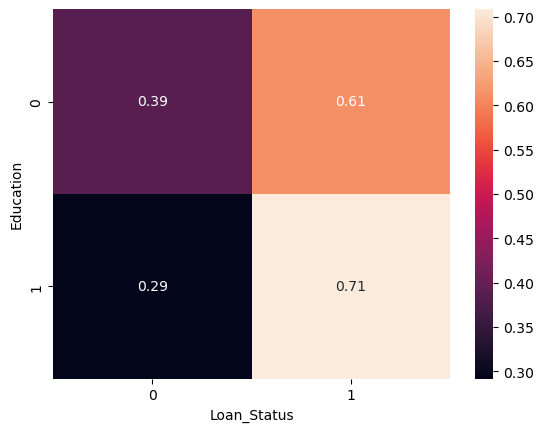

In [382]:
sns.heatmap(pd.crosstab(data['Education'], data['Loan_Status'], normalize='index'), annot=True)

*observation* : 
- Diplômés (Education = 1) :
   - 71% de prêts approuvés (0.71).
   - 29% de refus (0.29).
- Non diplômés (Education = 0) :
   - 61% de prêts approuvés (0.61).
   - 39% de refus (0.39). 

*interpretation* :

- Les diplômés ont un avantage clair :Un taux d'approbation plus élevé de 10 % (71% vs 61%) par rapport aux non-diplômés, ce qui est conforme aux attentes générales (les banques favorisent les profils éduqués, perçus comme moins risqués).
- Cependant, 29% des diplômés sont tout de même refusés, suggérant que d'autres facteurs  jouent un rôle clé. 

*les suppositions pour le 29% de refus* :

Bien que les diplômés aient un taux d'approbation plus élevé (71%), les 29% de refus peuvent s'expliquer potentiellement par :
- Antécédents de crédit défavorables (même avec un diplôme).
- Demandes de prêts trop ambitieuses par rapport aux revenus.
- Garanties insuffisantes (ex: pas de propriété en zone urbaine). 


In [383]:
print('Ce tableau représente le pourcentage de acceptation et de refus des personnes diplômées selon leur historique de crédit.  ')
pd.crosstab(data[data['Education'] == 1]['Credit_History'], data['Loan_Status'], normalize='index')

Ce tableau représente le pourcentage de acceptation et de refus des personnes diplômées selon leur historique de crédit.  


Loan_Status,0,1
Credit_History,,
0.0,0.904762,0.095238
1.0,0.199041,0.800959


- Lorsque Credit_History = 0 (mauvais historique), les demandes de prêt sont refusées dans 90.4% des cas, même pour les diplômés.
- donc les 29% de refus chez les diplômés s'expliquent principalement par un mauvais historique de crédit. Un diplôme ne compense pas ce risque perçu par les banques.

=> donc cela implique une forte relation entre le credit_history et le variable cible ( loan_status )

<span style="color:skyblue">Loan_Status VS credit_History  </span> 

Corrélation entre Credit_History et Loan_Status : 0.54


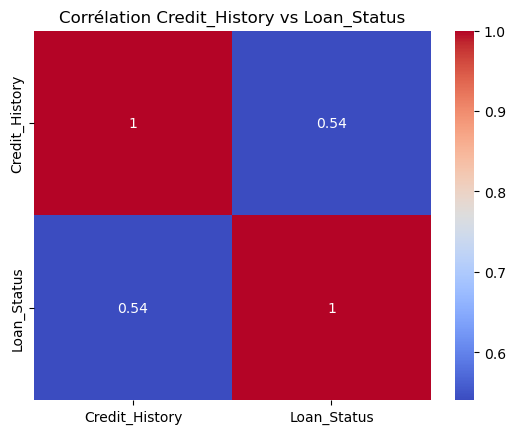

In [384]:
correlation = data['Credit_History'].corr(data['Loan_Status'])
print(f"Corrélation entre Credit_History et Loan_Status : {correlation:.2f}")

sns.heatmap(data[['Credit_History', 'Loan_Status']].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation Credit_History vs Loan_Status");

In [385]:
pd.crosstab(data['Credit_History'],data['Loan_Status'])

Loan_Status,0,1
Credit_History,,
0.0,82,7
1.0,110,415


les personnes avec un bon historique de crédit ont une grand chance d'approbation du prét que les autres

Variable: Credit_History
 p-value: 3.4183499979091188e-40


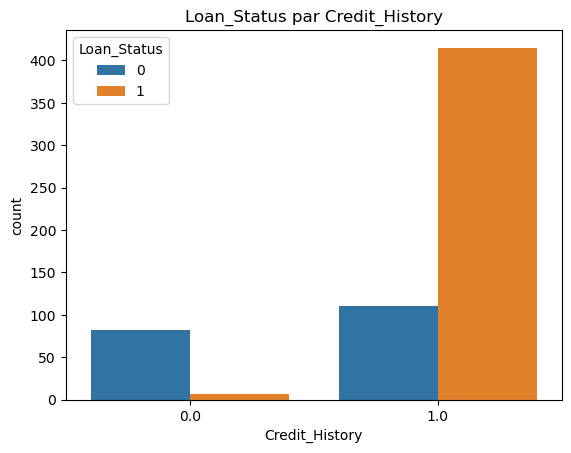

In [386]:
chi2_test('Credit_History')

<AxesSubplot:xlabel='Loan_Status', ylabel='Credit_History'>

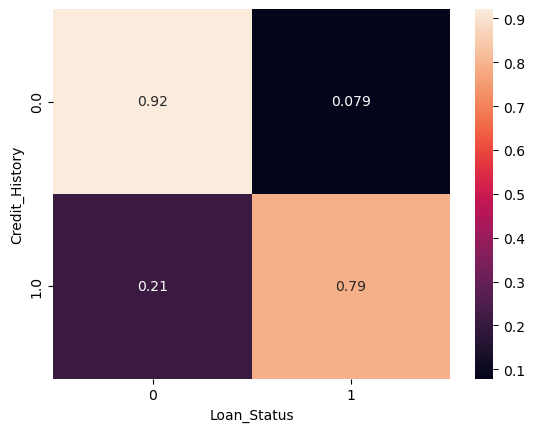

In [387]:
sns.heatmap(pd.crosstab(data['Credit_History'], data['Loan_Status'], normalize='index'), annot=True)

- Le test du Chi² rejette fortement l'hypothèse d'indépendance (p-value ≈ 0), confirmant que Credit_History influence significativement Loan_Status.

<span style="color:skyblue">Loan_Status VS Self_Employed  </span> 

In [388]:
pd.crosstab(data['Self_Employed'],data['Loan_Status'])

Loan_Status,0,1
Self_Employed,,
0,166,366
1,26,56


<AxesSubplot:xlabel='Loan_Status', ylabel='Self_Employed'>

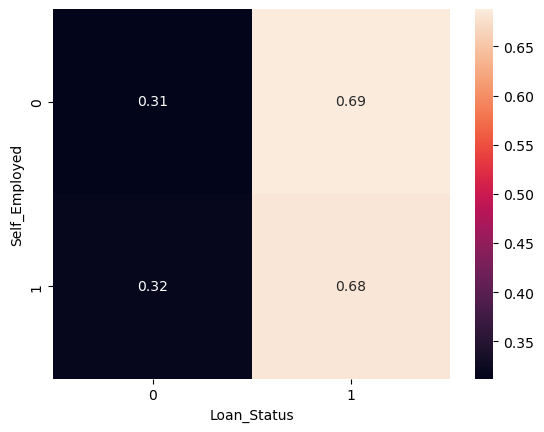

In [389]:
sns.heatmap(pd.crosstab(data['Self_Employed'],data['Loan_Status'],normalize='index'), annot=True)

- Bien que les taux d'approbation soient similaires (salariés : 69% vs indépendants : 68%), l'échantillon très déséquilibré (532 salariés vs 82 indépendants) rend cette comparaison peu fiable.

Variable: Self_Employed
 p-value: 1.0


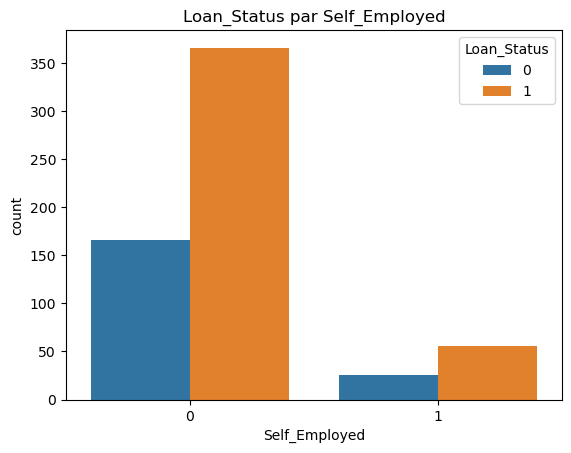

In [390]:
chi2_test('Self_Employed')

- p-value=1 >> 0.05 → Pas de relation statistiquement significative entre les deux variables 

<span style="color:skyblue">Loan_Status VS Property_Area  </span>

In [391]:
pd.value_counts(data['Property_Area'])


Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

Variable: Property_Area
 p-value: 0.0021360187811644937


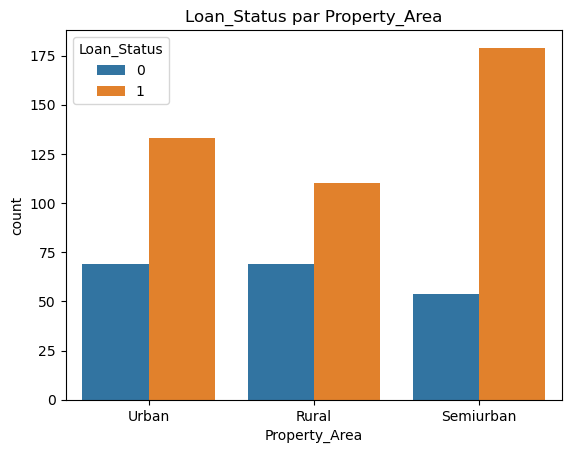

In [392]:
chi2_test('Property_Area')

- Le test du chi² appliqué à la variable Property_Area donne une p-value de 0.0021 (< 0.05), indiquant une relation statistiquement significative entre la zone de résidence et la probabilité d’obtention d’un prêt. Le graphique montre que les demandeurs résidant en zone semi-urbaine ont un taux d’acceptation de prêt plus élevé que ceux en zone urbaine ou rurale. Cela peut s'expliquer par des politiques bancaires différentes selon les zones ou des profils socio-économiques spécifiques.

<span style="color:blue">Loan_Status VS les variables numériques </span>

Test de **Student** 

- Le test de Student (ou t-test) est un test statistique qui permet de comparer les moyennes de deux groupes pour savoir si elles sont significativement différentes l’une de l’autre. 
- On l’utilise lorsqu’on veut tester si une variable numérique (ex. : ApplicantIncome) diffère selon une variable binaire (ex. : Loan_Status = Y/N).

Les Hypothéses : 



> - H0: Les moyennes des deux groupes sont égales
> - H1 : Les moyennes des deux groupes sont différentes 

In [393]:
from scipy.stats import ttest_ind

def student_test(var):
    group1 = data[data['Loan_Status'] == 1][var]
    group2 = data[data['Loan_Status'] == 0][var]
    stat,p = ttest_ind(group1, group2)
    print(f"Variable: {var} ")
    print("p_value :", p)
    sns.violinplot(data=data, x='Loan_Status', y=var)
    plt.title(f"{var} en fonction de Loan_Status")
    plt.show()

 <span style="color:skyblue">Loan_Status VS ApplicantIncome   </span>

Variable: ApplicantIncome 
p_value : 0.907287812130518


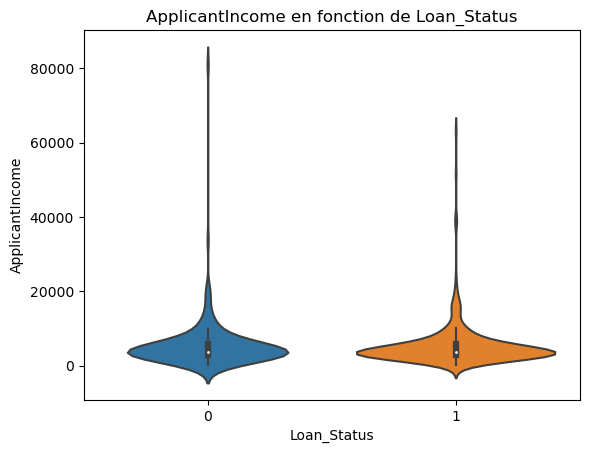

In [394]:
student_test('ApplicantIncome')

- Le test de Student appliqué à la variable ApplicantIncome donne une p-value de 0.91 (> 0.05), ce qui indique qu’il n’existe pas de différence significative de revenu moyen entre les demandeurs ayant obtenu un prêt et ceux ayant été refusés. Cette variable n’a donc pas d’impact déterminant sur la décision d’approbation, selon ce test.

- Le graphique en violon montre que la distribution des revenus (ApplicantIncome) est globalement similaire entre les demandeurs ayant obtenu un prêt (Loan_Status = 1) et ceux qui ont été refusés (Loan_Status = 0). La forme et la densité des distributions sont proches, avec des valeurs extrêmes dans les deux cas. Cela confirme les résultats du test de Student, indiquant qu’il n’y a pas de différence significative de revenu moyen entre les deux groupes.

 <span style="color:skyblue">Loan_Status VS LoanAmount   </span>

Variable: LoanAmount 
p_value : 0.41132365467805476


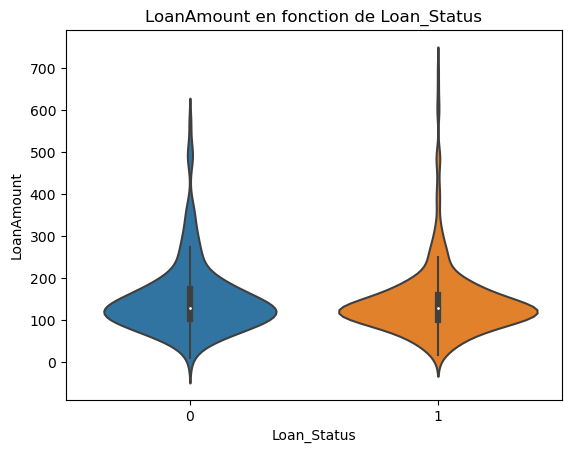

In [395]:
student_test('LoanAmount')

- Le test de Student appliqué à la variable LoanAmount donne une p-value de 0.41, ce qui est largement supérieur au seuil de 0.05. Cela indique qu’il n’existe pas de différence significative dans le montant du prêt moyen entre les demandes acceptées et refusées. Cette conclusion est visuellement confirmée par le violin plot, où les deux distributions sont très similaires.

In [396]:
data.head(
)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,1,0,5849,0.0,128.0,360.0,1.0,Urban,1
1,LP001003,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,Urban,1


## <span style="color:purple"> IV-Modèle de régression logistique </span>

 #####  <span style="color:green">Préparation des données pour le modéle </span>

<span style="color:blue">Encodage de Property_Area  </span>

Après le test du chi², on observe une relation significative entre la variable cible et la variable Property_Area. Nous allons donc l’encoder pour l’utiliser dans le modèle.

In [397]:
print(data['Property_Area'].value_counts())

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


In [398]:
property_area_dummies = pd.get_dummies(data['Property_Area'], prefix='Property_Area')
property_area_dummies = property_area_dummies.astype(int)  # Convertir True/False en 1/0
data = pd.concat([data, property_area_dummies], axis=1)
data.drop('Property_Area', axis=1, inplace=True)

In [399]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,1,0,0,1,0,5849,0.0,128.0,360.0,1.0,1,0,0,1
1,LP001003,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,0,1,0,0
2,LP001005,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,1,0,0,1
3,LP001006,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,1,0,0,1
4,LP001008,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,1,0,0,1


<span style="color:blue">Application de la méthode SMOTE pour équilibrer les classes prédictible  </span>

Diviser les données (train/test)

In [400]:
from sklearn.model_selection import train_test_split
X = data.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = data['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Standardiser les données

In [401]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Appliquer SMOTE sur les données d'entraînement

In [402]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [403]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [404]:
import numpy as np
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(unique, counts)))

{0: 337, 1: 337}


- Les deux classes sont désormais équilibrées pour les données  d'entraînement 

 #####  <span style="color:green">Entraînement du modéle (régression logistique)  </span>

Déterminer les meilleurs hyperparamétres en utilisants GridSearch

In [299]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [308]:
param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'max_iter': [1000],
    'class_weight': [ 'balanced'],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
)

grid_search.fit(X_train_resampled, y_train_resampled)

print(" Meilleurs paramètres :", grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
 Meilleurs paramètres : {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'liblinear'}


entrainer le modéle et faire la prédiction 

In [309]:
model = LogisticRegression(
    C=1,
    class_weight='balanced',
    solver='saga',
    max_iter=1000,
    random_state=42
)

model.fit(X_train_resampled, y_train_resampled)
y_pred=model.predict(X_test_scaled)

In [310]:
print("Accuracy :", accuracy_score(y_test, y_pred))

Accuracy : 0.8048780487804879


- Une précision de 0.80 (80%) signifie que le modèle de régression logistique prédit correctement 74% des cas sur les données de test

 #####  <span style="color:green">Evaluation du modéle (régression logistique)  </span>

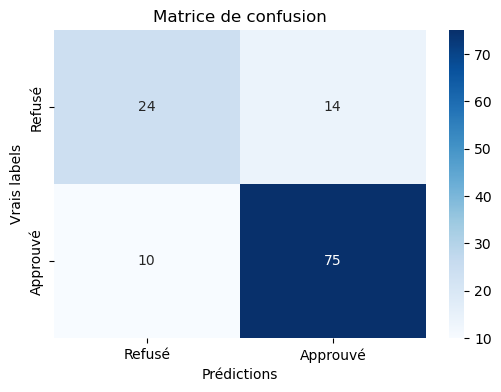

In [311]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Refusé', 'Approuvé'], yticklabels=['Refusé', 'Approuvé'])
plt.xlabel('Prédictions')
plt.ylabel('Vrais labels')
plt.title('Matrice de confusion')
plt.show()

- 75 vrais positifs : 75 prêts réellement approuvés ont été correctement prédits comme approuvés. 
- 10 faux négatifs  : 10 prêts approuvés en réalité ont été prédit comme refusés → ce sont des erreurs "ratées".
- 14 faux positifs  : 14 prêts refusés en réalité ont été prédit comme approuvés → erreur "optimiste".
- 24 vrais négatifs : 24 prêts réellement refusés ont été correctement prédits comme refusés.

> - le modèle est meilleur pour prédire les prêts approuvés (67 bien prédits vs. 18 mal prédits).
> - Il fait plus d’erreurs sur les refusés : il prédit parfois un prêt refusé comme approuvé (13 cas), ce qui peut être critique dans un vrai contexte bancaire.
> - Faux négatifs (18) peuvent être risqués aussi, car tu refuses des prêts à des gens qui auraient pu les recevoir. 

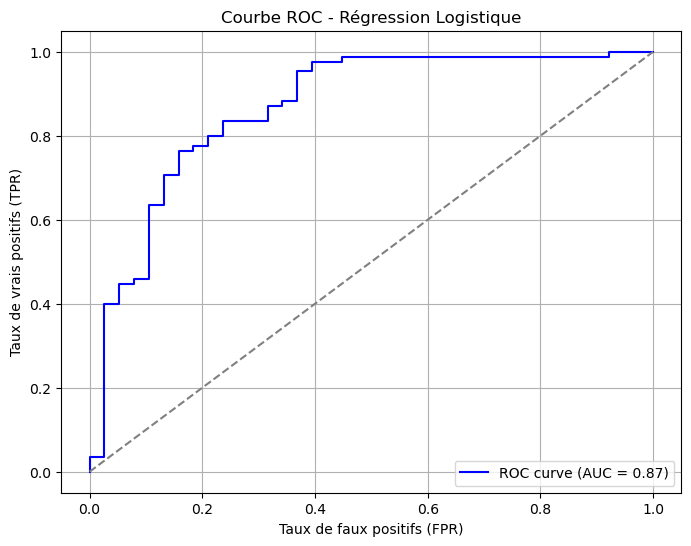

In [313]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prédire les probabilités de la classe positive (1 = prêt approuvé)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Calcul des valeurs ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcul de l'AUC
auc_v = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_v:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Régression Logistique')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

- AUC=0.87 Cela signifie que dans 87% des cas, ton modèle classe correctement un exemple positif (prêt approuvé) au-dessus d’un négatif (prêt refusé) en termes de probabilité.



<span style="color:blue">Odds Ratio (rapport de cotes) : relation de chaque variable avec la variable cible  </span>

In [323]:
odds_ratios = np.exp(model.coef_[0])
feature_names = X_train.columns

# Affichage des odds ratios
pd.Series(odds_ratios, index=feature_names).sort_values(ascending=False)

Credit_History             3.596705
Property_Area_Semiurban    1.210233
Married                    1.180489
Dependents                 1.167386
Education                  1.152691
ApplicantIncome            1.120417
Self_Employed              0.968966
Loan_Amount_Term           0.965807
Property_Area_Urban        0.964801
CoapplicantIncome          0.959669
Gender                     0.920252
LoanAmount                 0.865646
Property_Area_Rural        0.847438
dtype: float64

-  Credit_History (3.60) : C’est la variable la plus influente. Les individus ayant un bon historique de crédit ont environ 3.6 fois plus de chances d’obtenir un prêt que ceux ayant un mauvais ou aucun historique. Cela confirme l’importance cruciale de la crédibilité financière dans la décision d’approbation.
- Property_Area_Semiurban (1.21), Urban (≈0.96), Rural (0.85) : Les personnes résidant dans les zones semi-urbaines ont une légère probabilité plus élevée d’obtenir un prêt par rapport aux autres zones. À l’inverse, les zones rurales semblent légèrement défavorisées.
-  Married (1.18) : Les personnes mariées ont une probabilité légèrement plus élevée d’obtenir un prêt, possiblement en raison d’une perception de stabilité financière.
- Dependents (1.17) : Avoir des personnes à charge semble avoir un léger effet positif, peut-être perçu comme un besoin accru de soutien financier.
- Education (1.15) : Les emprunteurs éduqués ont une légère probabilité supérieure d’obtenir un prêt, ce qui peut refléter une confiance accrue des institutions financières.
- ApplicantIncome (1.12) : Comme attendu, un revenu plus élevé augmente légèrement la probabilité d’acceptation du prêt, mais l’effet reste modéré comparé à l’historique de crédit.

- Self_Employed (0.97) : Être travailleur indépendant réduit légèrement les chances d’obtention du prêt, sans effet majeur.
- Loan_Amount_Term (0.97) : La durée du prêt a un impact très faible, presque neutre. 
- CoapplicantIncome (0.96) et Gender (0.92) : Ces deux variables ont un effet très limité, voire légèrement négatif.
-  LoanAmount (0.87) : Un montant de prêt élevé diminue les chances d’acceptation, ce qui est logique puisque le risque pour la banque augmente.



 #####  <span style="color:green">Comparaison avec d'autre modéle (ex : RandomForest) </span>

In [405]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Créer et entraîner le modèle
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# 2. Prédictions
y_pred_rf = rf_model.predict(X_test_scaled)

# 3. Évaluation
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))



Accuracy: 0.8048780487804879

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.68        38
           1       0.85      0.87      0.86        85

    accuracy                           0.80       123
   macro avg       0.77      0.76      0.77       123
weighted avg       0.80      0.80      0.80       123



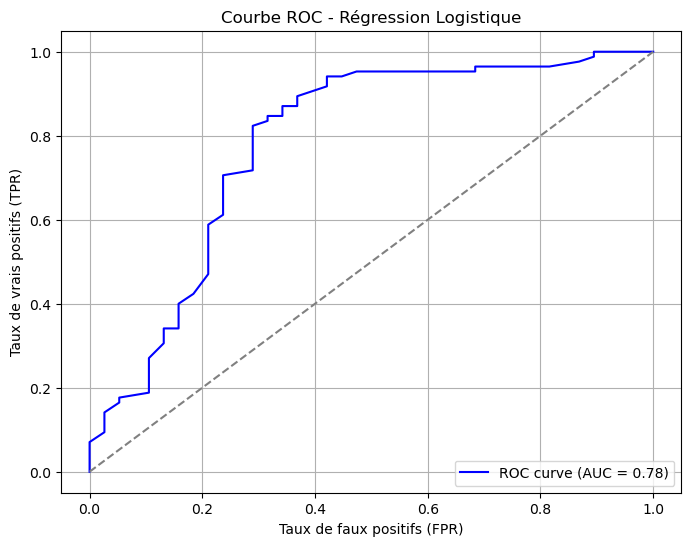

In [406]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prédire les probabilités de la classe positive (1 = prêt approuvé)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calcul des valeurs ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcul de l'AUC
auc_v = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_v:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Régression Logistique')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

- Bien que les deux modèles obtiennent la même précision globale (accuracy), la régression logistique présente un meilleur score AUC (0.87), ce qui indique qu’elle distingue mieux les classes positives et négatives. 

## <span style="color:purple"> V-Conclusion </span>

L’analyse de cette base de données de demandes de prêt bancaire a permis de mettre en évidence plusieurs facteurs influençant significativement l’acceptation d’un prêt. En particulier, l’historique de crédit est de loin le facteur le plus déterminant. Deux modèles ont été comparés : la régression logistique et la forêt aléatoire. Malgré une accuracy similaire (~80 %), la régression logistique présente une meilleure capacité de discrimination (AUC = 0.87 contre 0.78) tout en étant plus simple à interpréter grâce aux odds ratios. Elle est donc le modèle recommandé pour ce cas d’usage. Des améliorations peuvent être envisagées, notamment un meilleur traitement des données manquantes et l’exploration de modèles non linéaires plus complexes.